In [24]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csv

from numba import njit
from numpy.linalg import norm

from tqdm import tqdm

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import lr_scheduler
from torchmetrics import MeanAbsolutePercentageError

import seaborn as sns
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

from utility_funcs import *
from LJ_modeling_realization.includes.constants import *

import dill

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, ConstantKernel, RBF
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import Normalizer

In [25]:
model_type = "gpr"

In [26]:
class SklearnModel:
    def __init__(self, model):
        '''
        model - sklearn model
        '''
        self.model = model

    def __call__(self, X):
        return self.model.predict(X)

In [27]:
model_file_path = f'./trained_models/{model_type}_{CFG.N}_movements_K{CFG.K}.pickle'
model_vel_file_path = f'./trained_models/{model_type}_{CFG.N}_velocities_K{CFG.K}.pickle'

# Сетка предсказания сжатые будет выдавать и их надо будет возвращать к обычному скейлу
descaler_path = f'./trained_models/descaler_{CFG.N}_K{CFG.K}.pickle'
descaler_vel_path = f'./trained_models/descaler_vel_{CFG.N}_K{CFG.K}.pickle'

In [28]:
with open(model_file_path, 'rb') as handle:
    model = dill.load(handle)

with open(model_vel_file_path, 'rb') as handle:
    model_vel = dill.load(handle)

if model_type == "gpr":
    descaler = Descaler(1, 0)
    descaler_vel = Descaler(1, 0)
    model = SklearnModel(model)
    model_vel = SklearnModel(model_vel)
else:
    with open(descaler_path, 'rb') as handle:
        descaler = dill.load(handle)
    

In [29]:
CFG.N

2

In [30]:
def csv_row_to_state(coords_path, vels_path, row_number=0):
    '''
    This function will be mostly used to start integration and create header for csv to write into
    '''

    row_coords = np.array(pd.read_csv(
        coords_path
    ).iloc[row_number, :][1:]).reshape(CFG.N, 3)

    row_vels = np.array(pd.read_csv(
        vels_path
    ).iloc[0, :][1:]).reshape(CFG.N, 3)
    
    state = {i: [row_coords[i], row_vels[i]] for i in range(CFG.N)}


    return state

In [31]:
state = csv_row_to_state(
    f'./coords_and_movements/coords{CFG.N}.csv',
    f'./coords_and_movements/velocities{CFG.N}.csv',

    row_number=-1   # НАЧИНАЕМ ПРЕДСКАЗЫВАТЬ С КОНЦА ИЗВЕСТНОЙ ТРАЕКТОРИИ
)

In [32]:
state

{0: [array([2.45444906, 0.0452567 , 0.01312289]),
  array([-0.01021237, -0.00092358,  0.00040281])],
 1: [array([1.29585161, 2.46031814, 0.05882174]),
  array([ 0.01021237,  0.00092358, -0.00040281])]}

In [33]:
def _get_relative_positions(state, atom_number):
    '''
    This function processes one row of csv into something that we can work with

    Returns np.array matrix that consists of relative positions vectors for passed atom_number to every other atom
    and then we can chose only closest N_neighbours in the next functions
    
    row: df.iloc[row] - typeof(row): pd.Series
    
    returns: Rel_matrix, f_vec
    '''

    other_atom_numbers = [i for i in range(CFG.N) if i != atom_number]
    Rel_matrix = np.zeros([CFG.N - 1, 3])

    for i, other_numb in enumerate(other_atom_numbers):
        Rel_matrix[i] = state[atom_number][0] - state[other_numb][0]

    # print('rel_dists: ', Rel_matrix)

    return np.array(Rel_matrix)

def create_V_i(i, normalized_m, norms, r_cut=CFG.r_cut, p=CFG.p):
    '''
    normalized_m: matrix of relative distances, where rows - normalized vectors
    i: i-th component of r_cut and p, i in range 1..K (or in 0..K-1 in code)
    '''
    transf_vecs = make_matrix_transformed(normalized_m, norms[:, np.newaxis], r_cut[i], p[i])

    return np.sum(transf_vecs, axis=0)

# @njit(parallel=True)
def create_V(normalized_m, norms, K=CFG.K):
    '''
    creates V
    '''
    V = []
    for i in range(K):
        V.append(
            create_V_i(i, normalized_m, norms)
        )

    return np.stack(V)

In [34]:
# @njit(
#     parallel=True,
#     fastmath=True
#     )
def _calculate_matrix_for_atom(relative_distances, r_cut=CFG.r_cut, p=CFG.p, N_neig=CFG.N_neig, K=CFG.K, use_orthogonal=False, use_A_t=True):
    '''

    relative_distances: np.array matrix of relative distance vectors

    '''
    
    # Only closest N_neig are counting:
    indexlist = np.argsort(norm(relative_distances, axis=1))

    relative_distances = relative_distances[indexlist[len(relative_distances) - N_neig:]]

    norms = norm(relative_distances, axis=-1)

    normalized_rel_distances = relative_distances / norms[:, np.newaxis]

    V = create_V(normalized_rel_distances, norms)

    if use_orthogonal and CFG.K == 3:
        diagonal_V_matr = [[0] * CFG.K for i in range(K)]
        for i in range(K):
            diagonal_V_matr[i][i] = V[i][i]
        V = np.array(
            diagonal_V_matr
        )

    A = V / norm(V, axis=-1)[:, np.newaxis]

    if use_A_t:
        X = V @ A.T
    else:
        X = V

    return X, A

def get_matrix_for_atom(state, atom_number, N_neig=CFG.N_neig, use_orthogonal=True, use_A_t=True):
    '''

    This function will create X matrix for passed atom with
    arrays of r_cut and p of length k

    It is a wrapper for _get_relative_positions and _calculate_matrix_for_atom, so I can speed up matrix calculations
    with numba for _calculate_matrix_for_atom

    atom_number: a number of atom that we are passing
    row: one row from df_with_coords, i.e. df.iloc[index_of_row]

    '''
    # @njit
    def get_pinv(A):
        return np.linalg.pinv(A)

    # creating row of relative coordinates for concrete atom:
    relative_distances = _get_relative_positions(state=state, atom_number=atom_number)
    X, A = _calculate_matrix_for_atom(relative_distances=relative_distances, N_neig=N_neig, use_orthogonal=use_orthogonal, use_A_t=use_A_t)

    flat_X = np.concatenate([X.flatten(), state[atom_number][1]])

    # print(
    #     state
    # )
    
    return flat_X, get_pinv(A)

# %timeit get_matrix_for_atom(row=df.iloc[0], atom_number=1)

In [35]:
csv_naming_coords = []
for i in range(CFG.N):
    csv_naming_coords.extend([str(i) + "x", str(i) + "y", str(i) + "z"])
result_coords_csv = "./integration_res/result_coords.csv"

csv_naming_vels = []
for i in range(CFG.N):
    csv_naming_vels.extend([str(i) + "vx", str(i) + "vy", str(i) + "vz"])
result_vels_csv = "./integration_res/result_vels.csv"


def fill_csv(state, path, mode="coords"):
    '''
    fills csv after current step
    '''
    s = ''
    if mode == "coords":
        idx = 0
    else:
        idx = 1
    with open(path, "a") as f:
        for atom_numb in range(CFG.N):
            s += ',' + ",".join(list(state[atom_numb][idx].astype(str)))
        f.write(s[1:] + '\n')

def fill_xyz(state, path):
    '''
    fills xyz file after current step
    '''
    pass

In [36]:
def make_prediction(X, pinv_A, model):
    return pinv_A @ descaler(model(X.reshape(1, -1))).squeeze()

In [37]:
def make_predictions(state, model):
    '''
    predicting on multiple rows is faster
    '''
    Xs = []
    pinv_As = []
    for atom_num in range(CFG.N):
        X, pinv_A = get_matrix_for_atom(state=state, atom_number=atom_num)
        Xs.append(X)
        pinv_As.append(pinv_A)
    Xs = np.array(Xs, dtype=np.float32)
    pinv_As = np.array(pinv_As)
    preds = descaler(model(Xs))

    return [pinv_As[i] @ preds[i] for i in range(CFG.N)]

# make_predictions(state, model=model)

# make_predictions(state, model=model_vel)

In [38]:
def make_step(state):
    dses = make_predictions(state, model)
    dvs = make_predictions(state, model_vel)
    for atom_num in range(CFG.N):
        state[atom_num][0] += dses[atom_num]
        state[atom_num][1] += dvs[atom_num]
    
    return state

In [39]:
def integration_cycle(state, number_of_steps, xyz_path=None):
    '''
    state: starting state
    '''
    # print(state)
    for step in range(number_of_steps):
        fill_csv(state, result_coords_csv)
        fill_csv(state, result_vels_csv, mode="vels")

        fill_xyz(state, xyz_path)
        state = make_step(state)

        fill_csv(state, result_coords_csv)
        fill_xyz(state, xyz_path)

    return state

In [40]:
with open(result_coords_csv, "w") as f:
    f.truncate(0)
    csv.DictWriter(f, fieldnames=csv_naming_coords).writeheader()

with open(result_vels_csv, "w") as f:
    f.truncate(0)
    csv.DictWriter(f, fieldnames=csv_naming_coords).writeheader()

integration_cycle(state=state, number_of_steps=10)
None

---
# Исследование интегрирования:

In [41]:
@njit
def pot_energy(r1, r2, boundary_condtitions=boundary_conditions):
        # Boundary condition realisation:
    r = r1 - r2
    if boundary_condtitions:
        for i in range(3):
            if np.abs(r[i]) > L / 2:   # Если расстояние между двумя частицами больше L/2, то мы точно найдем в соседних клетках ближе
                r[i] = r[i] - L * np.sign(r[i])
    d = norm(r)
    return -4 * (pow(d, -6) - pow(d, -12))

def plot_energy(path_coords=result_coords_csv, path_vels=result_vels_csv, boundary_conditions=boundary_conditions):
    E = []
    try:
        coords = pd.read_csv(path_coords).drop(columns=["t"])
        vels = pd.read_csv(path_vels).drop(columns=["t"])
    except:
        coords = pd.read_csv(path_coords)
        vels = pd.read_csv(path_vels)
    
    for row_n in range(len(vels)):  # TODO: ЗДЕСЬ СТОИТ vels ПОТОМУ ЧТО У МЕНЯ ПОКА БАГА И В КООРДС НА ОДНУ СТРОЧКУ БОЛЬШЕ ПОЧЕМУ-ТО...
        V = 0
        T = 0
        for i in range(CFG.N):
            r_i = np.array(coords.iloc[row_n, (3 * i):(3 * i) + 3])

            for j in range(i + 1, CFG.N):
                r_j = np.array(coords.iloc[row_n, (3 * j):(3 * j) + 3])
                # print(r_i, r_j)
                V += pot_energy(r_i, r_j, boundary_condtitions=boundary_conditions)
        

        T = ((vels.iloc[row_n]) ** 2).sum() / 2
        E.append(T + V)

        print(
            f'{row_n}: K = {T}, V = {V}, E = {T + V}'
        )

    plt.figure(figsize=(10, 10))
    plt.plot(
        [i for i in range(len(E))], E
    )
    # plt.xlabel()

0: K = 0.00010530767611449746, V = -0.010791016423773739, E = -0.010685708747659242
1: K = 0.00012757536919202208, V = -0.010104810108841506, E = -0.009977234739649484
2: K = 0.00015431993448704532, V = -0.010104810108841506, E = -0.00995049017435446
3: K = 0.00018614160126052067, V = -0.009461019344916824, E = -0.009274877743656302
4: K = 0.00022367767567823377, V = -0.009461019344916824, E = -0.00923734166923859
5: K = 0.0002675994333350099, V = -0.008857353713837304, E = -0.008589754280502293
6: K = 0.000318608967251563, V = -0.008857353713837304, E = -0.00853874474658574
7: K = 0.0003774360480708441, V = -0.008291598703109368, E = -0.007914162655038524
8: K = 0.00044483501756476044, V = -0.008291598703109368, E = -0.007846763685544609
9: K = 0.000521581846813258, V = -0.007761619668522003, E = -0.007240037821708746


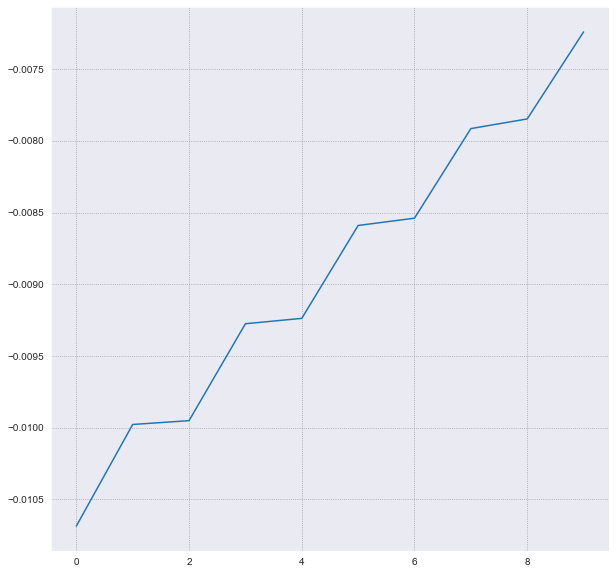

In [42]:
plot_energy(boundary_conditions=False)

In [43]:
def plot_error():
    '''
    Строит зависимость ошибки от шага интегрирования
    '''
    pass

In [44]:
def plot_trajectory():
    '''
    Строим x(step), y(step), z(step), сравниваем с трушной, сравниваем с Верле
    '''
    pass

**Короче пока что была трабла с граничными условиями: но пока частиц мало можно генерить траектории без граничных условий и на них потестить**

- Потом надо попробовать добавить учет граничных условий при вычислении матрицы для атома: для данного атома, если другой смещен далеко - учитываем это только для этого атома